## Install Dependencies

In [1]:
%pip install matplotlib

import numpy as np
from matplotlib import pyplot as plt
from statistics import mean, median


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
def printb(text: str) -> None:
    print("\033[1m" + text + "\033[0m")

## Load result data

In [3]:
import json 

with open("experiment_ga_results.json", "r") as results_file:
    experiments = json.load(results_file)

In [4]:
available_tags = set([
    experiment["params"]["tag"] for experiment in experiments
])
print("available tags:", available_tags)

available tags: {'test'}


In [5]:
seeds = [experiment["params"]["seed"] for experiment in experiments]
seeds = list(set(seeds))

print(seeds)

[0]


In [6]:
target_dir = "results_ga" # Used for storing plots

In [7]:
generations = set()
for experiment in experiments:
    generations.add(experiment["params"]["generations"])

assert len(generations) == 1, "Different generation values in experiments!"

generations = list(range(experiments[0]["params"]["generations"]))

In [8]:
no_cache_experiments = [
    experiment for experiment in experiments if experiment["params"]["cache_size"] == 0
]

cache_enabled_experiments = [
    experiment for experiment in experiments if experiment["params"]["cache_size"] > 0
]

## Plot best and mean fitness

Best and mean fitness, averaged across seeds:


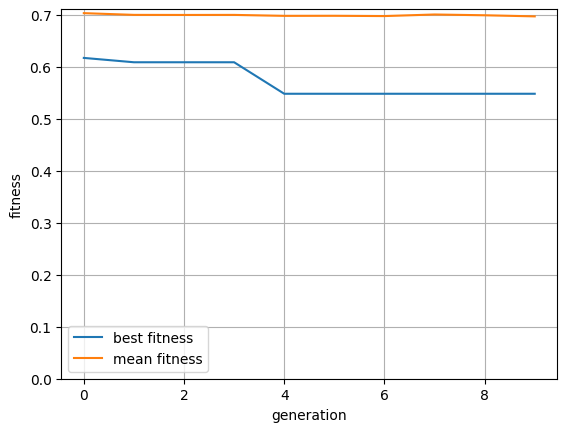

In [9]:
best_fitness_values = []
mean_fitness_values = []

for generation in generations:

    sel_best_fitness_values = [
        experiment["generations"][generation]["best_fitness"] for experiment in experiments
    ]
    best_fitness_values.append(mean(sel_best_fitness_values))
    
    sel_mean_fitness_values = [
        experiment["generations"][generation]["mean_fitness"] for experiment in experiments
    ]
    mean_fitness_values.append(mean(sel_mean_fitness_values))
    
ax = plt.subplot()
ax.plot(generations, best_fitness_values, label="best fitness")
ax.plot(generations, mean_fitness_values, label="mean fitness")
ax.set_xlabel("generation")
ax.set_ylabel("fitness")
ax.set_ylim(0)

printb("Best and mean fitness, averaged across seeds:")

plt.legend()
plt.grid()
plt.show()

## Plot simulation time


Net simulation time, averaged across seeds:


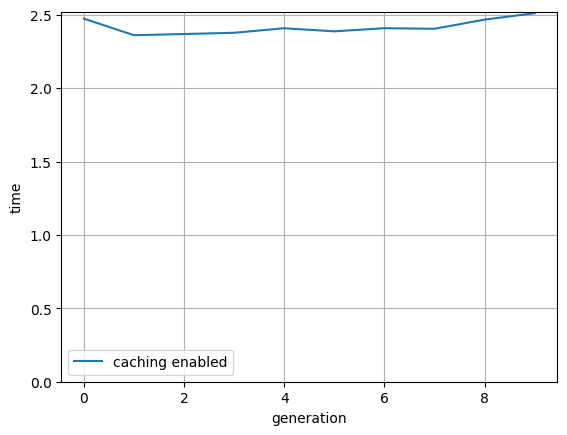

In [10]:
# durations_no_cache = []
durations_with_cache = []

for generation in generations:
    # duration_no_cache = mean([
    #     experiment["generations"][generation]["simulate_without_cache"]["duration"] for experiment in no_cache_experiments
    # ])
    # durations_no_cache.append(durations_no_cache)

    duration_with_cache = mean([
        experiment["generations"][generation]["simulate_using_cache"]["duration"] for experiment in cache_enabled_experiments
    ])
    durations_with_cache.append(duration_with_cache)


ax = plt.subplot()
# ax.plot(generations, durations_no_cache, label="no cache")
ax.plot(generations, durations_with_cache, label="caching enabled")
ax.set_xlabel("generation")
ax.set_ylabel("time")
ax.set_ylim(0)

printb("Net simulation time, averaged across seeds:")

plt.legend()
plt.grid()
plt.show()

## Plot redundancy

Population redundancy, averaged across seeds:


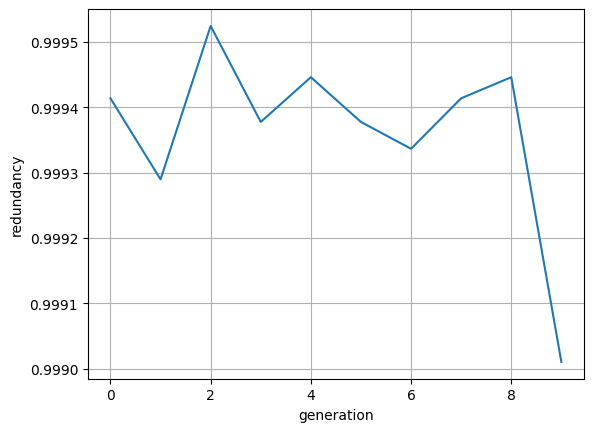

In [11]:
redundancies = []

for generation in generations:

    sel_redundancies = [
        experiment["generations"][generation]["population_redundancy"] for experiment in experiments
    ]
    redundancies.append(mean(sel_redundancies))

ax = plt.subplot()
ax.plot(generations, redundancies)
ax.set_xlabel("generation")
ax.set_ylabel("redundancy")
# ax.set_ylim(0)

printb("Population redundancy, averaged across seeds:")

plt.grid()
plt.show()